<a href="https://colab.research.google.com/github/aayushhyadav/MIA/blob/feature%2Fcifar10/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.0 MB/s

In [ ]:
!pip install -U matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 72.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!pip install -U pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.3 which is incompatible.
tensorflow-privacy 0.8.12 requires pandas~=1.4, but you have pandas 2.1.3 which is incompatible.


In [ ]:
!pip install -U tensorflow-datasets

In [ ]:
pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import math
import numpy as np
from numpy import trapz
import statistics
import random
import seaborn as sns
import ot
import scipy

/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [ ]:
'''
  # generates examples with equal class distribution
'''
def get_equal_class_distribution(data_x, data_y):
  class_dist = [0] * 10

  examples = list()
  train_X = list()
  train_y = list()

  for i in range(len(data_y)):
    if(class_dist[data_y[i][0]] <= 2900):
      class_dist[data_y[i][0]] += 1
      examples.append(i)

  for i in range(len(examples)):
    train_X.append(data_x[examples[i]])
    train_y.append(data_y[examples[i]])

  train_X = np.array(train_X)
  train_y = np.array(train_y)

  print(f"{data_x.shape, train_X.shape}")
  print(f"{data_y.shape, train_y.shape}")

  return train_X, train_y

In [ ]:
'''
  # extracts examples with unequal class distributions
  # examples corresponding to classes, 1, 3, 5, 7, 9 are varied
'''
def get_unequal_class_distribution(data_x, data_y, class_1, class_3, class_5, class_7, class_9):
  class_dist = [0] * 10

  examples = list()
  train_X = list()
  train_y = list()

  for i in range(len(data_y)):
    if(data_y[i][0] == 1 and class_dist[data_y[i][0]] < class_1):
      class_dist[data_y[i][0]] += 1
      examples.append(i)
    elif(data_y[i][0] == 3 and class_dist[data_y[i][0]] < class_3):
      class_dist[data_y[i][0]] += 1
      examples.append(i)
    elif(data_y[i][0] == 5 and class_dist[data_y[i][0]] < class_5):
      class_dist[data_y[i][0]] += 1
      examples.append(i)
    elif(data_y[i][0] == 7 and class_dist[data_y[i][0]] < class_7):
      class_dist[data_y[i][0]] += 1
      examples.append(i)
    elif(data_y[i][0] == 9 and class_dist[data_y[i][0]] < class_9):
      class_dist[data_y[i][0]] += 1
      examples.append(i)
    elif(data_y[i][0] == 0 or data_y[i][0] == 2 or data_y[i][0] == 4 or data_y[i][0] == 6 or data_y[i][0] == 8):
      class_dist[data_y[i][0]] += 1
      examples.append(i)

  for i in range(len(examples)):
    train_X.append(data_x[examples[i]])
    train_y.append(data_y[examples[i]])

  train_X = np.array(train_X)
  train_y = np.array(train_y)

  print(f"{data_x.shape, train_X.shape}")
  print(f"{data_y.shape, train_y.shape}")

  return train_X, train_y

In [ ]:
'''
  # loads cifar-10 dataset
  # flattens the dataset
  # performs one hot encoding on target values
'''
def load_dataset():
  (train_X, train_y), (test_X, test_y) = tf.keras.datasets.cifar10.load_data()

  # spliting the training set further to have approximately equal number of examples in train and test sets
  train_X, add_test_X, train_y, add_test_y = train_test_split(train_X, train_y, test_size = 0.4, random_state = 42)
  test_X = np.concatenate((test_X, add_test_X))
  test_y = np.concatenate((test_y, add_test_y))

  class_examples_train = [0] * 10
  class_examples_test = [0] * 10

  # for setting class imbalance to 0
  # train_X, train_y = get_equal_class_distribution(train_X, train_y)

  # for introducing class imbalance
  train_X, train_y = get_unequal_class_distribution(train_X, train_y, 10, 10, 10, 10, 15)

  for example in train_y:
    class_examples_train[example[0]] += 1
  for example in test_y:
    class_examples_test[example[0]] += 1

  for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(train_X[i])
  plt.show()

  print(f'class distribution for training dataset - {class_examples_train}')
  print(f'class distribution for testing dataset - {class_examples_test}')
  print(f'class imbalance - {statistics.pstdev(class_examples_train)}')
  print(f'training examples - {sum(class_examples_train)}')

  ohe_train_y = tf.keras.utils.to_categorical(train_y)
  ohe_test_y = tf.keras.utils.to_categorical(test_y)

  return train_X, test_X, ohe_train_y, ohe_test_y

In [ ]:
'''
  # perfroms feature scaling on training and test sets
'''
def standardize(train, test):
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  return train_norm, test_norm

In [ ]:
'''
  # creates a 2d CNN
'''
def create_model(optimizer, loss):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  # model.add(tf.keras.layers.Dense(10, activation='relu'))

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [ ]:
'''
  # creates a 2d CNN model with dropout layers
'''
def create_model_with_reg(optimizer, loss):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.1))

  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.1))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
'''
  # creates a vgg 16 model
'''
def create_vgg16(optimizer, loss):
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.MaxPool2D((2, 2), strides=1))

  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.MaxPool2D((2, 2), strides=1))

  model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.MaxPool2D((2, 2), strides=1))

  model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.MaxPool2D((2, 2), strides=1))

  model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.MaxPool2D((2, 2), strides=1))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(4096, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(4096, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

In [ ]:
'''
  # plots the loss and accuracy for training and validation sets
'''
def plot_learning_curves(history):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.set_title('Cross Entropy Loss')
  ax1.plot(history.history['loss'], color = 'blue', label = 'train')
  ax1.plot(history.history['val_loss'], color = 'red', label = 'validation')

  print('cross entropy loss for validation set')
  print(history.history['val_loss'])

  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'], color = 'blue', label = 'train')
  ax2.plot(history.history['val_accuracy'], color = 'red', label = 'validation')

  plt.show()

In [ ]:
'''
  # computes entropy for probability vectors
  # prob_vec - probability vector
'''
def cal_entropy(prob_vec):
  entropy = 0

  for prob in prob_vec:
    if(prob != 0):
      entropy += prob * math.log(prob, 10)

  return -1 * entropy

In [ ]:
'''
  # computes standard deviation for probability vector
'''
def cal_std(prob_vec):
  mean = statistics.mean(prob_vec)
  variance = 0

  for prob in prob_vec:
    variance += (prob - mean) ** 2
  variance /= len(prob_vec)

  return math.sqrt(variance)

In [ ]:
'''
  # calculates AUC score for attack model using trapezoidal method
  # train_vec - entropy for output prediction vectors of training examples
  # test_vec - entropy for output prediction vectors of testing examples
  # pos_count - number of examples which are members of training set
  # neg_count - number of examples which are non-members of training set
  # inc_threshold - controls the number of thresholds for which AUC is computed
'''
def cal_auc(train_vec, test_vec, pos_count, neg_count, inc_threshold = 0.1):
  threshold = 0
  tpr_list, fpr_list = list(), list()
  tuple_tpr, tuple_fpr = list(), list()
  points = list()
  auc = 0

  while(threshold <= 1):
    tp_count = 0
    fp_count = 0

    for val in train_vec:
      if(val <= threshold):
        tp_count += 1

    for val in test_vec:
      if(val <= threshold):
        fp_count += 1

    tpr = tp_count / pos_count
    fpr = fp_count / neg_count

    tpr_list.append(tpr)
    fpr_list.append(fpr)

    threshold += inc_threshold

  for i in range(len(tpr_list)):
    points.append([fpr_list[i], tpr_list[i]])

  points.sort()

  for i in range(len(points) - 1):
    tuple_tpr.append([points[i][1], points[i + 1][1]])
    tuple_fpr.append([points[i][0], points[i + 1][0]])

  auc = sum(np.trapz(tuple_tpr, tuple_fpr))

  plt.scatter(fpr_list, tpr_list)
  plt.show()

  return auc

In [ ]:
# computes the threshold by choosing the top 10 percentile of the metric under consideration
def get_threshold(vec):
  return np.percentile(vec, 90)

In [ ]:
'''
  # computes the precision and recall for attack model
'''
def cal_pre_recall(train_vec, test_vec, threshold):
  tp = 0
  fp = 0
  fn = 0

  for val in train_vec:
    if(val <= threshold):
      tp += 1
    else:
      fn += 1

  for val in test_vec:
    if(val <= threshold):
      fp += 1

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  return precision, recall

In [ ]:
'''
  # computes the l2 norm of logits
'''
def get_clipping_val(list_logits):
  l2_norms = []

  for logits in list_logits:
    l2_norms.append(np.linalg.norm(logits))

  return l2_norms

In [ ]:
'''
  # adds noise to logits using gaussian mechanism
  # clipping value s is the 60th percentile of l2 norms of logits
  # returns noisy logits
'''
def dp_logits(logits, l2_norms):
  delta = 1 / train_X.shape[0]
  hist, bins = np.histogram(l2_norms)
  s = np.percentile(hist, 60)
  epsilon = 500
  sigma = np.sqrt(2 * np.log(1.25 / delta)) * (s / epsilon)

  for i in range(10):
    logits[i] = logits[i] + np.random.normal(loc=0, scale=sigma)

  return logits

In [ ]:
'''
  # converts logits to probabilities
'''
def logit_to_prob(logits):
  return tf.nn.softmax(logits)

In [ ]:
'''
  # computes the model accuracy after dp-logits has been applied
'''
def cal_dp_logits_acc(y_pred_list, y_true_list):
  correct_class = 0
  size = len(y_pred_list)

  for i in range(size):
    if(np.argmax(y_pred_list[i]) == np.argmax(y_true_list[i])):
      correct_class += 1

  print(f'classification accuracy - {correct_class / size}')

In [ ]:
'''
  # makes the distribution of metrics (entropy, std, max probability) of test set similar to training set
  # num_class is the number of classes in the classification task
  # max_prob_train is the list of maximum probabilities of output prediction vectors of training examples
  # max_prob_class is the class predicted by the model for a specific test example
  # returns a list of probabilities for the specific test example
'''
def make_metric_dist_same(num_class, max_prob_train, max_prob_class):
  p = [0] * num_class

  p[max_prob_class]  = random.choice(max_prob_train)
  rem_p = 1 - p[max_prob_class]

  for i in range(num_class):
    if(i != max_prob_class and rem_p > 0):
      p[i] = random.uniform(0, min(rem_p, p[max_prob_class]))
      rem_p -= p[i]

  if(rem_p > 0):
    while(True):
      index = p.index(random.choice(p))
      if(index != max_prob_class):
        p[index] += rem_p
        break

  return p

In [ ]:
# computes average entropy, standard deviation, and maximum posterior probability
# for prediction vector of training set examples

def compute_train_metrics(prob_vec_train):
  entropy_train = list()
  std_train = list()
  max_prob_train = list()
  max_prob_train_per_class = [[]] * 10

  sum_entropy = 0
  sum_std = 0
  sum_max_prob = 0

  for prob_vec in prob_vec_train:
    cur_entropy = cal_entropy(prob_vec)
    cur_std = cal_std(prob_vec)
    cur_max_prob = max(prob_vec)

    entropy_train.append(cur_entropy)
    std_train.append(cur_std)

    max_prob_train.append(cur_max_prob)
    pred_class = prob_vec.tolist().index(max(prob_vec))
    max_prob_train_per_class[pred_class].append(cur_max_prob)

    sum_entropy = sum_entropy + cur_entropy
    sum_std = sum_std + cur_std
    sum_max_prob += cur_max_prob

  avg_train_entropy = sum_entropy / len(prob_vec_train)
  avg_train_std = sum_std / len(prob_vec_train)
  avg_train_max_prob = sum_max_prob / len(prob_vec_train)

  print(f"Avg train entropy - {avg_train_entropy}, Avg train std - {avg_train_std}, Avg train max probability - {avg_train_max_prob}")

  return entropy_train, std_train, max_prob_train, avg_train_entropy, avg_train_std, avg_train_max_prob

In [ ]:
# computes average entropy, standard deviation, and maximum posterior probability
# for prediction vector of test set examples

def compute_test_metrics(prob_vec_test):
  entropy_test = list()
  std_test = list()
  max_prob_test = list()

  sum_entropy = 0
  sum_std = 0
  sum_max_prob = 0

  for prob_vec in prob_vec_test:
    cur_entropy = cal_entropy(prob_vec)
    cur_std = cal_std(prob_vec)
    cur_max_prob = max(prob_vec)

    entropy_test.append(cur_entropy)
    std_test.append(cur_std)
    max_prob_test.append(cur_max_prob)

    sum_entropy = sum_entropy + cur_entropy
    sum_std = sum_std + cur_std
    sum_max_prob += cur_max_prob

  avg_test_entropy = sum_entropy / len(prob_vec_test)
  avg_test_std = sum_std / len(prob_vec_test)
  avg_test_max_prob = sum_max_prob / len(prob_vec_test)

  print(f"Avg test entropy - {avg_test_entropy}, Avg test std - {avg_test_std}, Avg test max probability - {avg_test_max_prob}")

  return entropy_test, std_test, max_prob_test, avg_test_entropy, avg_test_std, avg_test_max_prob

In [ ]:
# create and train the dp-sgd model

def dg_sgd_model(train_norm, train_y, test_norm, test_y, optimizer, loss):
  model = create_model(optimizer, loss)
  history = model.fit(train_norm, train_y, epochs = 100, batch_size = 40, validation_data = (test_norm, test_y))
  return model, history

In [ ]:
# setup for dp-logits

def dp_logits_setup(model, train_norm, test_norm):
  logit_vec_train = model.predict(train_norm)
  logit_vec_test = model.predict(test_norm)
  prob_vec_train = []
  prob_vec_test = []

  clipping_val = get_clipping_val(logit_vec_train)

  for i in range(len(logit_vec_train)):
    logit_vec_train[i] = dp_logits(logit_vec_train[i], clipping_val)
    prob_vec_train.append(logit_to_prob(logit_vec_train[i]))

  for i in range(len(logit_vec_test)):
    logit_vec_test[i] = dp_logits(logit_vec_test[i], clipping_val)
    prob_vec_test.append(logit_to_prob(logit_vec_test[i]))

  prob_vec_train = np.array(prob_vec_train)
  prob_vec_train[0]

  prob_vec_test = np.array(prob_vec_test)
  prob_vec_test[0]

In [ ]:
def plot_entropy_dist(entropy_train, entropy_test, entropy_shrinked):
  figure, axis = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

  sns.distplot(ax=axis[0], a=entropy_train, bins=10)
  sns.distplot(ax=axis[1], a=entropy_test, bins=10)
  sns.distplot(ax=axis[2], a=entropy_shrinked, bins=10)

  axis[0].set_title("Entropy Distribution for Training Set")
  axis[1].set_title("Entropy Distribution for Test Set")
  axis[2].set_title("Metric Mapping")

  axis[0].set_xlabel("Entropy")
  axis[1].set_xlabel("Entropy")
  axis[2].set_xlabel("Entropy")

In [ ]:
def plot_std_dist(std_train, std_test, std_shrinked):
  figure, axis = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

  sns.distplot(ax=axis[0], a=std_train, bins=10)
  sns.distplot(ax=axis[1], a=std_test, bins=10)
  sns.distplot(ax=axis[2], a=std_shrinked, bins=10)

  axis[0].set_title("Std Distribution for Training Set")
  axis[1].set_title("Std Distribution for Test Set")
  axis[2].set_title("Metric Mapping")

  axis[0].set_xlabel("Standard Deviation")
  axis[1].set_xlabel("Standard Deviation")
  axis[2].set_xlabel("Standard Deviation")

In [ ]:
def plot_max_prob_dist(max_prob_train, max_prob_test, max_prob_shrinked):
  figure, axis = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

  sns.distplot(ax=axis[0], a=max_prob_train, bins=10)
  sns.distplot(ax=axis[1], a=max_prob_test, bins=10)
  sns.distplot(ax=axis[2], a=max_prob_shrinked, bins=10)

  axis[0].set_title("Max Probability Distribution for Training Set")
  axis[1].set_title("Max Probability Distribution for Test Set")
  axis[2].set_title("Metric Mapping")

  axis[0].set_xlabel("Max probability")
  axis[1].set_xlabel("Max probability")
  axis[2].set_xlabel("Max probability")

In [ ]:
def compute_scaled_metrics(train_values, test_values, mm_values, sampled_size):
  sampled_train_metric = random.sample(train_values, sampled_size)
  sampled_test_metric = random.sample(test_values, sampled_size)
  sampled_mapped_metric = random.sample(mm_values, sampled_size)

  sampled_train_metric_sum = sum(sampled_train_metric)
  sampled_test_metric_sum = sum(sampled_test_metric)
  sampled_mapped_metric_sum = sum(sampled_mapped_metric)

  scaled_train_metric = np.array(sampled_train_metric).reshape((sampled_size, 1)) / sampled_train_metric_sum
  scaled_test_metric = np.array(sampled_test_metric).reshape((sampled_size, 1)) / sampled_test_metric_sum
  scaled_mapped_metric = np.array(sampled_mapped_metric).reshape((sampled_size, 1)) / sampled_mapped_metric_sum

  return scaled_train_metric, scaled_test_metric, scaled_mapped_metric

In [ ]:
def reshape_to_1d(scaled_train_metric, scaled_test_metric, scaled_mapped_metric):
  scaled_train_metric = scaled_train_metric.reshape((len(scaled_train_metric)))
  scaled_test_metric = scaled_test_metric.reshape((len(scaled_test_metric)))
  scaled_mapped_metric = scaled_mapped_metric.reshape(len(scaled_mapped_metric))
  return scaled_train_metric, scaled_test_metric, scaled_mapped_metric

170498071/170498071 [==============================] - 2s 0us/step
((30000, 32, 32, 3), (15144, 32, 32, 3))
((30000, 1), (15144, 1))


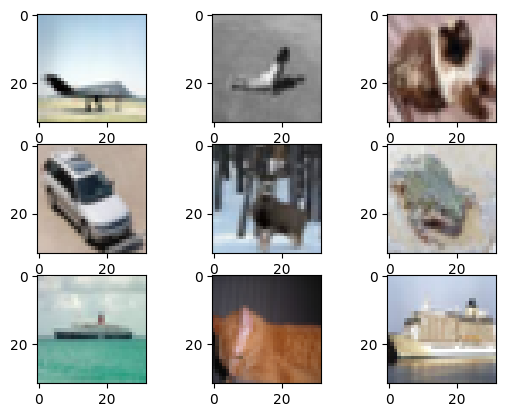

class distribution for training dataset - [3027, 10, 2991, 10, 3056, 10, 3060, 10, 2955, 15]
class distribution for testing dataset - [2973, 2979, 3009, 3041, 2944, 3033, 2940, 2993, 3045, 3043]
class imbalance - 1503.666266164138
training examples - 15144
Epoch 1/50
379/379 [==============================] - 43s 109ms/step - loss: 1.3776 - accuracy: 0.4064 - val_loss: 4.0226 - val_accuracy: 0.2302
Epoch 2/50
379/379 [==============================] - 41s 108ms/step - loss: 1.1879 - accuracy: 0.5011 - val_loss: 4.0584 - val_accuracy: 0.2713
Epoch 3/50
379/379 [==============================] - 33s 86ms/step - loss: 1.1053 - accuracy: 0.5516 - val_loss: 4.3439 - val_accuracy: 0.2862
Epoch 4/50
379/379 [==============================] - 41s 109ms/step - loss: 1.0394 - accuracy: 0.5785 - val_loss: 4.3577 - val_accuracy: 0.3010
Epoch 5/50
379/379 [==============================] - 32s 83ms/step - loss: 1.0020 - accuracy: 0.6020 - val_loss: 4.1521 - val_accuracy: 0.3049
Epoch 6/50
379/379 [

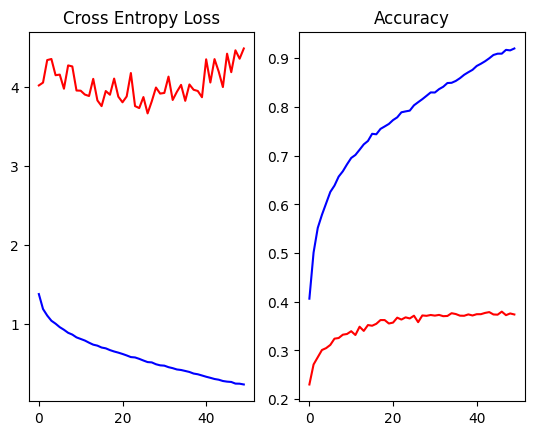

938/938 [==============================] - 14s 15ms/step
Avg train entropy - 0.13289501505728607, Avg train std - 0.26871628239334916, Avg train max probability - 0.8894130135760916
Avg test entropy - 0.19330375156570337, Avg test std - 0.25311375518279594, Avg test max probability - 0.8325122810597221
Avg test entropy - 0.1525875860409052, Avg test std - 0.2670620521489202, Avg test max probability - 0.8898438074880097


<ipython-input-29-c0c945c6c159>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ax=axis[0], a=entropy_train, bins=10)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-inpu

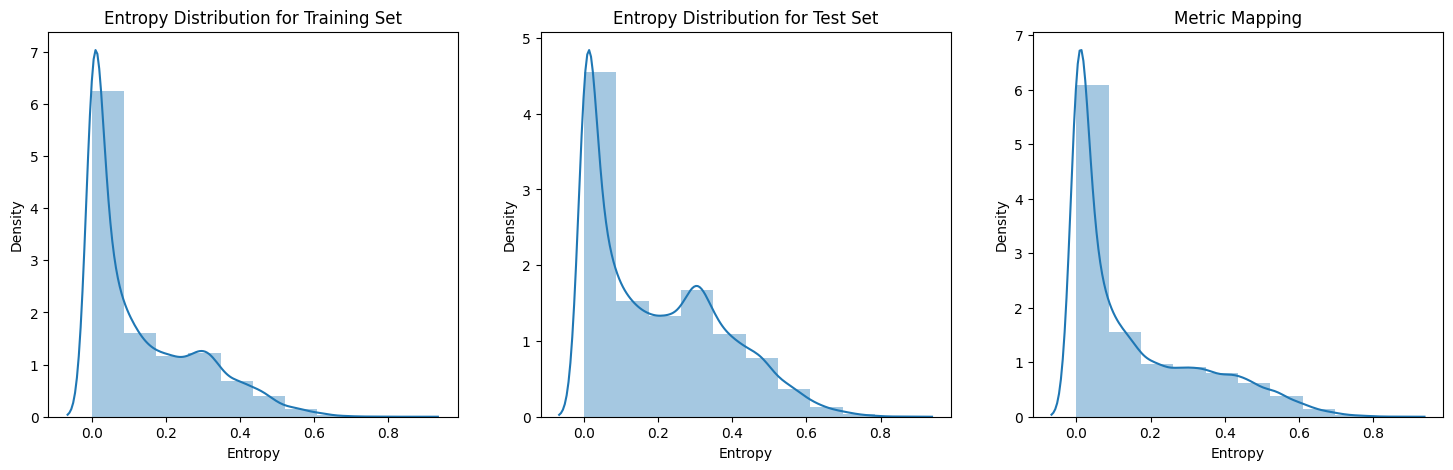

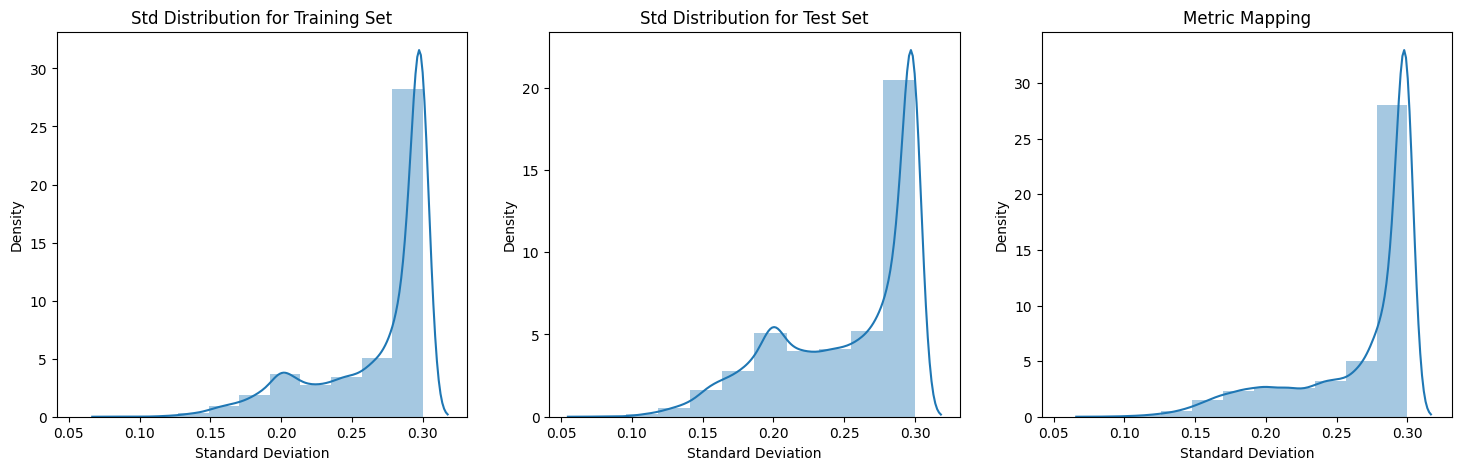

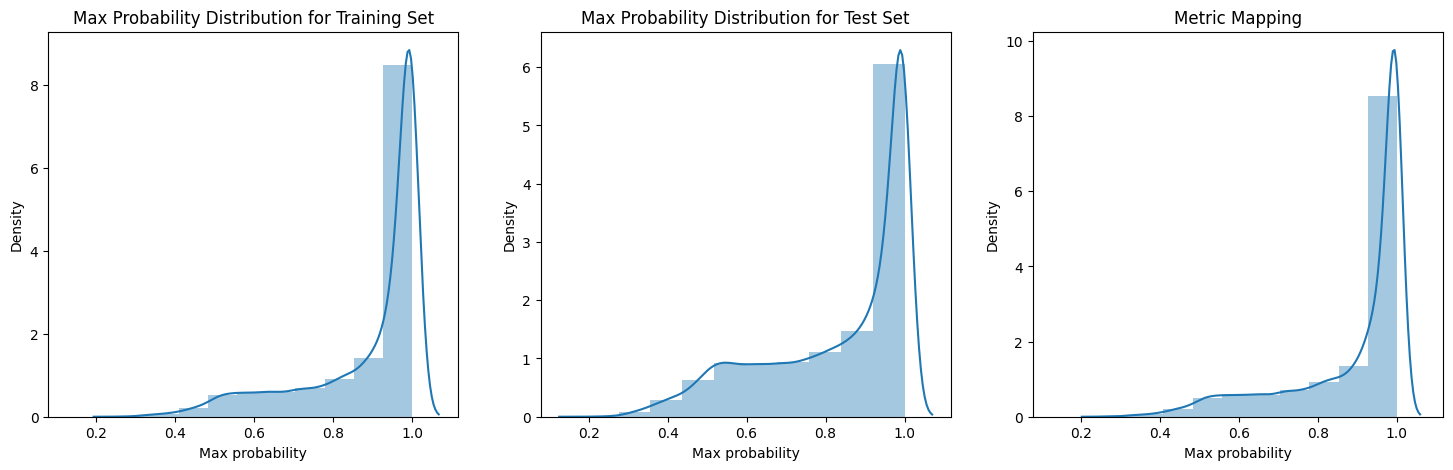

In [ ]:
train_X, test_X, train_y, test_y = load_dataset()
train_norm, test_norm = standardize(train_X, test_X)

# DP-SGD optimizer
dp_optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=2,
    noise_multiplier=1,
    num_microbatches=8,
    learning_rate=0.001)

# SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)

model = create_model(optimizer, loss)
history = model.fit(train_norm, train_y, epochs = 50, batch_size = 40, validation_data = (test_norm, test_y))

# for model with dropout layers
# reg_model = create_model_with_reg(optimizer, loss)
# history = reg_model.fit(train_norm, train_y, epochs = 30, batch_size = 40, validation_data = (test_norm, test_y))

# for vgg 16 model
# vgg_model = create_vgg16(optimizer, loss)
# history = vgg_model.fit(train_norm, train_y, epochs = 3, batch_size = 40, validation_data = (test_norm, test_y))

plot_learning_curves(history)

prob_vec_train = model.predict(train_norm)
prob_vec_test = model.predict(test_norm)

# prob_vec_train = reg_model.predict(train_norm)
# prob_vec_test = reg_model.predict(test_norm)

# prob_vec_train = vgg_model.predict(train_norm)
# prob_vec_test = vgg_model.predict(test_norm)

entropy_train, std_train, max_prob_train, avg_train_entropy, avg_train_std, avg_train_max_prob = compute_train_metrics(prob_vec_train)
entropy_test, std_test, max_prob_test, avg_test_entropy, avg_test_std, avg_test_max_prob = compute_test_metrics(prob_vec_test)

solutions = []

# applying metric mapping
for p in prob_vec_test:
  p = p.tolist()
  cur_max_prob = p.index(max(p))
  solutions.append(make_metric_dist_same(10, max_prob_train, cur_max_prob))

entropy_shrinked, std_shrinked, max_prob_shrinked, avg_shrinked_entropy, avg_shrinked_std, avg_shrinked_max_prob = compute_test_metrics(np.array(solutions))

# plot metric distributions
plot_entropy_dist(entropy_train, entropy_test, entropy_shrinked)
plot_std_dist(std_train, std_test, std_shrinked)
plot_max_prob_dist(max_prob_train, max_prob_test, max_prob_shrinked)

# calculate auc score using entropy as the parameter
cal_auc(entropy_train, entropy_shrinked, len(entropy_train), len(entropy_shrinked), 0.00001)

# calculate auc score using standard deviation as the parameter
cal_auc(std_train, std_shrinked, len(std_train), len(std_shrinked), 0.00001)

# calculate auc score using max probability as the parameter
cal_auc(max_prob_train, max_prob_shrinked, len(max_prob_train), len(max_prob_shrinked), 0.0001)

threshold = get_threshold(entropy_shrinked)
precision, recall = cal_pre_recall(entropy_train, entropy_shrinked, threshold)
print(f"precision - {precision}, recall - {recall}")

threshold = get_threshold(std_shrinked)
precision, recall = cal_pre_recall(std_train, std_test, threshold)
print(f"precision - {precision}, recall - {recall}")

threshold = get_threshold(max_prob_shrinked)
precision, recall = cal_pre_recall(max_prob_train, max_prob_test, threshold)
print(f"precision - {precision}, recall - {recall}")

In [ ]:
# computes 1-wasserstein distance for entropy metric
scaled_train_metric, scaled_test_metric, scaled_mapped_metric = compute_scaled_metrics(entropy_train, entropy_test, entropy_shrinked, 100)
scaled_train_metric, scaled_test_metric, scaled_mapped_metric = reshape_to_1d(scaled_train_metric, scaled_test_metric, scaled_mapped_metric)

print(f'similarity between entropy curves (prior to applying metric mapping) - {scipy.stats.wasserstein_distance(scaled_test_metric, scaled_train_metric)}')
print(f'similarity between entropy curves (post applying metric mapping) - {scipy.stats.wasserstein_distance(scaled_mapped_metric, scaled_train_metric)}')

similarity between entropy curves (prior to applying metric mapping) - 0.0028924137111996694
similarity between entropy curves (post applying metric mapping) - 0.0009553942373367154


In [ ]:
# computes 1-wasserstein distance for std metric
scaled_train_metric, scaled_test_metric, scaled_mapped_metric = compute_scaled_metrics(std_train, std_test, std_shrinked, 100)
scaled_train_metric, scaled_test_metric, scaled_mapped_metric = reshape_to_1d(scaled_train_metric, scaled_test_metric, scaled_mapped_metric)

print(f'similarity between std curves (prior to applying metric mapping) - {scipy.stats.wasserstein_distance(scaled_test_metric, scaled_train_metric)}')
print(f'similarity between std curves (post applying metric mapping) - {scipy.stats.wasserstein_distance(scaled_mapped_metric, scaled_train_metric)}')

similarity between std curves (prior to applying metric mapping) - 0.0004170369025398858
similarity between std curves (post applying metric mapping) - 0.00031437789362350236


In [ ]:
# computes 1-wasserstein distance for max probability metric
scaled_train_metric, scaled_test_metric, scaled_mapped_metric = compute_scaled_metrics(max_prob_train, max_prob_test, std_shrinked, 100)
scaled_train_metric, scaled_test_metric, scaled_mapped_metric = reshape_to_1d(scaled_train_metric, scaled_test_metric, scaled_mapped_metric)

print(f'similarity between max probability curves (prior to applying metric mapping) - {scipy.stats.wasserstein_distance(scaled_test_metric, scaled_train_metric)}')
print(f'similarity between max probability curves (post applying metric mapping) - {scipy.stats.wasserstein_distance(scaled_mapped_metric, scaled_train_metric)}')

similarity between max probability curves (prior to applying metric mapping) - 0.0004812679206952453
similarity between max probability curves (post applying metric mapping) - 0.00046717142933641495
